# XGB Model Training and SHAP computation

**Authors:**<br>
Lin Lee Cheong <br>
Tesfagabir Meharizghi<br>

**Date:**<br>
03/31/2021


This notebook trains XGBoost model based on the given data (synthetic/real). In addition, it also computes the SHAP, LRP and attention weights for each trained model. Once the importance scores are computed, it also calculates intersection similarity where it gives a score of similarity between the predicted features and ground truth.

Finally, it visualizes the different feature importance scores and per-observation scores.

In [41]:
# pip install nb-black

In [42]:
#! pip install shap
#! pip install xgboost

In [43]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import os
import time
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.inspection import permutation_importance
import re
import json

import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import xgb_utils
import imp_utils

## XGB Model Training

### Constants

In [45]:
# Feature suffices that help predict the positive or negative class
# HELPING_FEATURES_SUFFICES = ["_A", "_H", "_U"]  # Noises Removed

IS_SYNTHETIC = True  # If dataset is synthetic/real
TRAIN_MODEL = True

# Whether to preprocess data
PREPROCESS_DATA = True

# Whether to save SHAP scores
SAVE_SHAP_OUTPUT = True

# Whether to ouput SHAP explainer expected value
OUTPUT_SHAP_EXPLAINER = True

# Whether to shuffle val & test dataset for shap visualization purposes
SHUFFLE = False

SEQ_LEN = 30
DATA_TYPE = "event"

USE_FREQ = True  # Whether to use feature frequencies or one-hot for data preprocessing

TARGET_COLNAME = "label"
UID_COLNAME = "patient_id"

MODEL_NAME = "xgb"

# SHAP related constants
N_BACKGROUND = 300  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = True  # If negative examples are used as background
BACKGROUND_POSITIVE_ONLY = False  # If positive examples are used as background
TEST_POSITIVE_ONLY = False  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = True  # Whether to consider the absolute value of a shap score #TODO: Check this before running.


TRAIN_DATA_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/train.csv"
VALID_DATA_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/val.csv"
TEST_DATA_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/test.csv"
VOCAB_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/vocab.pkl"

MODEL_SAVE_PATH = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/models/model_{'{}'}.pkl"
IMP_SAVE_PATH_PATTERN = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/importances/{'{}'}_imp_{'{}'}.pkl"  # Feature importances path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

# Dataset preprocessing
x_TRAIN_ONE_HOT_PATH = (
    f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/data/train_one_hot.csv"
)
x_VALID_ONE_HOT_PATH = (
    f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/data/val_one_hot.csv"
)
x_TEST_ONE_HOT_PATH = (
    f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/data/test_one_hot.csv"
)

x_TRAIN_DATA_PATH = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/data/train.csv"
x_VALID_DATA_PATH = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/data/val.csv"
x_TEST_DATA_PATH = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/data/test.csv"

OUTPUT_RESULTS_PATH = (
    f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/train_results/results.csv"
)
PARAMS_PATH = (
    f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/train_results/model_params.json"
)


# Test Patients for Visualization (from Test Set)
SELECTED_PATIENTS = ["VHCSIEPRI8", "MIP0F9ZOUM", "79A4PHXNE6", "CW780GL0AX"]

EARLY_STOPPING_ROUNDS = 3

MODEL_PARAMS = {
    "n_jobs": 25,
    "random_state": 7,
    "max_depth": 5,
    "n_estimators": 500,
    "eval_metric": "auc",
    "learning_rate": 0.5,
    "reg_alpha": 0.2,
    "reg_lambda": 0.3,
    "colsample_bytree": 0.35,
    "use_label_encoder": False,
}

In [46]:
if TRAIN_MODEL:
    # Model Output Directory
    model_save_dir = os.path.dirname(MODEL_SAVE_PATH)
    shap_save_dir = os.path.dirname(IMP_SAVE_PATH_PATTERN)
    output_results_dir = os.path.dirname(OUTPUT_RESULTS_PATH)

    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    if os.path.exists(shap_save_dir):
        shutil.rmtree(shap_save_dir)
    if os.path.exists(output_results_dir):
        shutil.rmtree(output_results_dir)

    os.makedirs(model_save_dir)
    os.makedirs(shap_save_dir)
    os.makedirs(output_results_dir)
    print(f"New directory created: {model_save_dir}")
    print(f"New directory created: {shap_save_dir}")
    print(f"New directory created: {output_results_dir}")

New directory created: ./output/event/30/xgb/models
New directory created: ./output/event/30/xgb/importances
New directory created: ./output/event/30/xgb/train_results


## 2. XGBoost Model Training

### Data Preprocessing

In [47]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(21000, 34)


,patient_id,29,28,27,26,25,24,23,22,21,...,6,5,4,3,2,1,0,sequence_type,proba,label
0,42R8IXZIK2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,quad_injury_N,pneumonia_H,hay_fever_N,backache_N,Chronic_Obstructive_Pulmonary_Disease_A,hay_fever_N,dental_exam_N,AH,0.7,1
1,YU03GXIPV2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,troponin_H,congestive_heart_failure_A,myopia_N,peanut_allergy_N,backache_N,hay_fever_N,myopia_N,AH,0.7,1
2,Q1915GS5V5,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cold_sore_N,ingrown_nail_N,pneumonia_H,myopia_N,dental_exam_N,dental_exam_N,hay_fever_N,AHH,0.8,1
3,4S1YJIM5NK,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,ACL_tear_N,ankle_sprain_N,ventricular_aneurysm_A,dental_exam_N,peanut_allergy_N,annual_physical_N,AH,0.7,1
4,6W22CK0326,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,catheter_ablation_U,hay_fever_N,headache_N,pacemaker_U,myopia_N,annual_physical_N,foot_pain_N,HUU,0.2,0


In [48]:
tokens = xgb_utils.get_valid_tokens(df, SEQ_LEN)

In [49]:
if PREPROCESS_DATA:
    xgb_utils.prepare_data(
        TRAIN_DATA_PATH,
        x_TRAIN_ONE_HOT_PATH,
        x_TRAIN_DATA_PATH,
        SEQ_LEN,
        TARGET_COLNAME,
        tokens,
        s3_dir="",
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        VALID_DATA_PATH,
        x_VALID_ONE_HOT_PATH,
        x_VALID_DATA_PATH,
        SEQ_LEN,
        TARGET_COLNAME,
        tokens,
        s3_dir="",
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        TEST_DATA_PATH,
        x_TEST_ONE_HOT_PATH,
        x_TEST_DATA_PATH,
        SEQ_LEN,
        TARGET_COLNAME,
        tokens,
        s3_dir="",
        use_freq=USE_FREQ,
    )
# else:
#     local_dir = os.path.dirname(x_TRAIN_DATA_PATH)
#     xgb_utils.copy_data_to_s3(local_dir, s3_output_data_dir)

Sucess!
Sucess!
Sucess!


### XGBoost Model Training

In [50]:
df_train = pd.read_csv(x_TRAIN_ONE_HOT_PATH)
df_val = pd.read_csv(x_VALID_ONE_HOT_PATH)
df_test = pd.read_csv(x_TEST_ONE_HOT_PATH)

In [51]:
df_train.head()

,patient_id,hypertension_A,ARB_U,electrolyte_imbalance_H,sleep_apnea_treatment_U,foot_pain_N,Brain_Natriuretic_Peptide_H,sleep_apnea_H,diuretics_U,myopia_N,...,cut_finger_N,pulmonary_embolism_A,ventricular_hypertrophy_A,pneumonia_H,metabolic_disorder_H,cold_sore_N,Percutaneous_Coronary_Intervention_U,cardiomyopathy_A,catheter_ablation_U,label
0,42R8IXZIK2,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,YU03GXIPV2,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,1,0,0,0,1
2,Q1915GS5V5,0,0,0,0,1,0,0,0,1,...,2,0,0,1,0,2,0,0,0,1
3,4S1YJIM5NK,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,6W22CK0326,0,0,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [52]:
count_0 = df_train[TARGET_COLNAME].value_counts()[0]
count_1 = df_train[TARGET_COLNAME].value_counts()[1]
print(
    f"Train Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

count_0 = df_val[TARGET_COLNAME].value_counts()[0]
count_1 = df_val[TARGET_COLNAME].value_counts()[1]
print(
    f"Val Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

count_0 = df_test[TARGET_COLNAME].value_counts()[0]
count_1 = df_test[TARGET_COLNAME].value_counts()[1]
print(
    f"Test Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

print(df_train.shape)
df_train.head()

Train Classes Count: 0-->10681, 1-->10319, Total-->21000
Val Classes Count: 0-->3597, 1-->3403, Total-->7000
Test Classes Count: 0-->3644, 1-->3356, Total-->7000
(21000, 47)


,patient_id,hypertension_A,ARB_U,electrolyte_imbalance_H,sleep_apnea_treatment_U,foot_pain_N,Brain_Natriuretic_Peptide_H,sleep_apnea_H,diuretics_U,myopia_N,...,cut_finger_N,pulmonary_embolism_A,ventricular_hypertrophy_A,pneumonia_H,metabolic_disorder_H,cold_sore_N,Percutaneous_Coronary_Intervention_U,cardiomyopathy_A,catheter_ablation_U,label
0,42R8IXZIK2,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,YU03GXIPV2,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,1,0,0,0,1
2,Q1915GS5V5,0,0,0,0,1,0,0,0,1,...,2,0,0,1,0,2,0,0,0,1
3,4S1YJIM5NK,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,6W22CK0326,0,0,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [53]:
# Get feature names
feature_names = [
    col for col in df_train.columns.tolist() if col not in [UID_COLNAME, TARGET_COLNAME]
]

In [54]:
model_save_dir = os.path.dirname(MODEL_SAVE_PATH)
if TRAIN_MODEL:
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)

    rounds = 1  # Saves model every one-epoch

    check_point = xgb.callback.TrainingCheckPoint(
        directory=model_save_dir,
        iterations=rounds,
        name="model",
        as_pickle=True,
    )

    X_train, y_train = df_train[feature_names], df_train[TARGET_COLNAME]
    X_val, y_val = df_val[feature_names], df_val[TARGET_COLNAME]

    print("Training XGB Classifier...")
    model = XGBClassifier(**MODEL_PARAMS)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        # eval_set=[(X_train, y_train)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=True,
        callbacks=[check_point],
    )

    # Save Model Parameters
    if not os.path.isdir(os.path.split(PARAMS_PATH)[0]):
        os.makedirs(os.path.split(PARAMS_PATH)[0])

    with open(PARAMS_PATH, "w") as fp:
        json.dump(MODEL_PARAMS, fp)

    print("Successfully Done!")

Training XGB Classifier...
[0]	validation_0-auc:0.69052
[1]	validation_0-auc:0.76289
[2]	validation_0-auc:0.78881
[3]	validation_0-auc:0.79790
[4]	validation_0-auc:0.79617
[5]	validation_0-auc:0.79802
[6]	validation_0-auc:0.80224
[7]	validation_0-auc:0.80286
[8]	validation_0-auc:0.80394
[9]	validation_0-auc:0.80328
[10]	validation_0-auc:0.80569
[11]	validation_0-auc:0.80395
[12]	validation_0-auc:0.80681
[13]	validation_0-auc:0.80734
[14]	validation_0-auc:0.80898
[15]	validation_0-auc:0.81004
[16]	validation_0-auc:0.80980
[17]	validation_0-auc:0.80910
[18]	validation_0-auc:0.80919
Successfully Done!


In [55]:
# Get list of models paths
model_paths = imp_utils.get_model_paths(
    model_save_dir, model_name=MODEL_NAME, sort=True
)
model_paths[:3]

['./output/event/30/xgb/models/model_1.pkl',
 './output/event/30/xgb/models/model_2.pkl',
 './output/event/30/xgb/models/model_3.pkl']

In [67]:
if TRAIN_MODEL:

    train_aucs = []
    val_aucs = []
    test_aucs = []

    train_losses = []
    val_losses = []
    test_losses = []

    gain_permute_tau_scores = []

    val_shap_sim_lst = []
    test_shap_sim_lst = []

    val_gain_shap_tau_lst = []

    val_permute_shap_tau_lst = []
    epochs = []
    for model_path in model_paths:
        # Get epoch number from the model path
        model_fname = model_path
        model_fname = os.path.basename(model_path)
        epoch = int(re.sub("\D", "", model_fname))
        epochs.append(epoch)

        xgb_model = xgb_utils.load_xgb_classifier(model_path, MODEL_PARAMS)

        # feature_importances = xgb_model.feature_importances_
        feature_names = xgb_model.get_booster().feature_names

        # Compute AUCs
        train_y_true = df_train[TARGET_COLNAME]
        train_y_pred = xgb_model.predict_proba(df_train[feature_names])[:, 1]
        train_auc = roc_auc_score(train_y_true, train_y_pred)
        train_aucs.append(train_auc)

        val_y_true = df_val[TARGET_COLNAME]
        val_y_pred = xgb_model.predict_proba(df_val[feature_names])[:, 1]
        val_auc = roc_auc_score(val_y_true, val_y_pred)
        val_aucs.append(val_auc)

        test_y_true = df_test[TARGET_COLNAME]
        test_y_pred = xgb_model.predict_proba(df_test[feature_names])[:, 1]
        test_auc = roc_auc_score(test_y_true, test_y_pred)
        test_aucs.append(test_auc)

        # Losses
        train_loss = log_loss(train_y_true, train_y_pred)
        train_losses.append(train_loss)
        val_loss = log_loss(val_y_true, val_y_pred)
        val_losses.append(val_loss)
        test_loss = log_loss(test_y_true, test_y_pred)
        test_losses.append(test_loss)

        xgb_gain = pd.DataFrame(
            (xgb_model.get_booster().get_score(importance_type="gain")).items()
        )
        xgb_gain.columns = ["features", "xgb_gain"]

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "sk_gain"]

        df_gains = xgb_gain.merge(feat_imp, how="inner", on=["features"])

        df_gains["xgb_rank"] = df_gains["xgb_gain"].rank(ascending=False)
        df_gains["sk_rank"] = df_gains["sk_gain"].rank(ascending=False)
        df_gains.sort_values("xgb_gain", ascending=False)
        # print(df_gains)

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "gain_scores"]
        feat_imp.set_index("features", inplace=True)
        feat_imp.sort_values("gain_scores", ascending=False, inplace=True)
        # feat_imp.plot.bar(figsize=(10, 5))
        # plt.title("Model Feature Importance Scores")

        # Check permutation
        perm_imp = permutation_importance(
            xgb_model, df_val[feature_names], df_val[TARGET_COLNAME]
        )

        perm_df = pd.DataFrame()
        perm_df["features"] = feature_names
        perm_df["perm_scores"] = perm_imp.importances_mean
        perm_df.sort_values("perm_scores", ascending=False, inplace=True)
        perm_df.set_index("features", inplace=True)
        # perm_df.plot.bar(figsize=(10, 5))
        # plt.title("Permutation Importance Scores")

        feat_imp = feat_imp.merge(perm_df, left_index=True, right_index=True)
        feat_imp["gain_rank"] = feat_imp.gain_scores.rank(ascending=False)
        feat_imp["permute_rank"] = feat_imp.perm_scores.rank(ascending=False)

        gain_rank = feat_imp.sort_values("gain_rank").index
        permute_rank = feat_imp.sort_values("permute_rank").index

        # checking ===========================
        check = False
        if check:
            plt.figure()
            plt.scatter(feat_imp.gain_scores, feat_imp.perm_scores)
            plt.title(f"gain_perm_{epoch}")
            plt.show()

        tau_score = imp_utils.get_wtau(feat_imp.gain_scores, feat_imp.perm_scores)
        gain_permute_tau_scores.append(tau_score)

        val_shap_results, explainer = imp_utils.compute_xgb_shap(
            xgb_model,
            df_train,
            df_val,
            UID_COLNAME,
            TARGET_COLNAME,
            explainer=None,
            negative_only=True,
        )

        (val_features, val_scores, val_patients) = val_shap_results
        avg_sim, _ = imp_utils.get_all_intersection_similarity(
            val_scores,
            val_features,
            freedom=0,
            is_synthetic=IS_SYNTHETIC,
        )
        val_shap_sim_lst.append(avg_sim)

        # Compute the shap global feature importance
        shap_global = np.absolute(np.array(val_scores)).mean(axis=0)
        df_shap = pd.DataFrame()
        df_shap["features"] = feature_names
        df_shap["shap_scores"] = shap_global.tolist()
        df_shap.set_index("features", inplace=True)
        # df_shap["shap_rank"] = df_shap.scores.rank(ascending=False)
        # df_shap.sort_values("scores", ascending=False, inplace=True)

        vals = feat_imp.merge(df_shap, left_index=True, right_index=True)
        vals["gain_rank"] = vals.gain_scores.rank(ascending=False)
        vals["shap_rank"] = vals.shap_scores.rank(ascending=False)

        gain_rank = vals.sort_values("gain_rank").index
        shap_rank = vals.sort_values("shap_rank").index
        perm_rank = vals.sort_values("permute_rank").index

        tau_score_shap = imp_utils.get_wtau(vals.gain_scores, vals.shap_scores)
        val_gain_shap_tau_lst.append(tau_score_shap)

        test_shap_results, _ = imp_utils.compute_xgb_shap(
            xgb_model,
            df_train,
            df_test,
            UID_COLNAME,
            TARGET_COLNAME,
            explainer,
            negative_only=True,
        )
        (test_features, test_scores, test_patients) = test_shap_results
        avg_sim, _ = imp_utils.get_all_intersection_similarity(
            test_scores,
            test_features,
            freedom=0,
            is_synthetic=IS_SYNTHETIC,
        )
        test_shap_sim_lst.append(avg_sim)

        tau_permute_shap = imp_utils.get_wtau(vals.perm_scores, vals.shap_scores)

        val_permute_shap_tau_lst.append(tau_permute_shap)

        if check:
            plt.figure()
            plt.scatter(vals.permute_rank, vals.shap_rank)
            plt.title(f"perm_shap_{epoch}: {val_permute_shap}")
            plt.show()

        # Save training results to file.
        shap_path = IMP_SAVE_PATH_PATTERN.format("val", epoch)
        results = imp_utils.save_xgb_results(
            val_patients, val_features, val_scores, val_y_true, val_y_pred, shap_path
        )

        shap_path = IMP_SAVE_PATH_PATTERN.format("test", epoch)
        results = imp_utils.save_xgb_results(
            test_patients,
            test_features,
            test_scores,
            test_y_true,
            test_y_pred,
            shap_path,
        )
        del xgb_model
        print(
            f"Epoch: {epoch:02} | Train Loss={train_loss:.4} | Train AUC={train_auc:.4} | Val Loss={val_loss:.4} | Val AUC={val_auc:.4} | TAU={tau_score:.4}"
        )

Epoch: 01 | Train Loss=0.603 | Train AUC=0.7637 | Val Loss=0.6048 | Val AUC=0.7629 | TAU=0.8451
Epoch: 02 | Train Loss=0.5755 | Train AUC=0.7877 | Val Loss=0.5754 | Val AUC=0.7888 | TAU=0.719
Epoch: 03 | Train Loss=0.5525 | Train AUC=0.7985 | Val Loss=0.5525 | Val AUC=0.7979 | TAU=0.7174
Epoch: 04 | Train Loss=0.5454 | Train AUC=0.8015 | Val Loss=0.5485 | Val AUC=0.7962 | TAU=0.7104
Epoch: 05 | Train Loss=0.5382 | Train AUC=0.8064 | Val Loss=0.5433 | Val AUC=0.798 | TAU=0.6822
Epoch: 06 | Train Loss=0.5302 | Train AUC=0.8115 | Val Loss=0.5354 | Val AUC=0.8022 | TAU=0.7296
Epoch: 07 | Train Loss=0.5259 | Train AUC=0.8134 | Val Loss=0.5317 | Val AUC=0.8029 | TAU=0.7444
Epoch: 08 | Train Loss=0.5221 | Train AUC=0.8155 | Val Loss=0.5282 | Val AUC=0.8039 | TAU=0.6933
Epoch: 09 | Train Loss=0.5203 | Train AUC=0.8167 | Val Loss=0.5277 | Val AUC=0.8033 | TAU=0.696
Epoch: 10 | Train Loss=0.5175 | Train AUC=0.821 | Val Loss=0.5258 | Val AUC=0.8057 | TAU=0.7082
Epoch: 11 | Train Loss=0.5151 | Tra

In [68]:
if TRAIN_MODEL:
    # Aggregate results
    columns = [
        "train_AUC",
        "val_AUC",
        "test_AUC",
        "train_Loss",
        "val_Loss",
        "test_Loss",
        "gain_permute_tau",
        "val_GT_shap_sim",
        "test_GT_shap_sim",
        "val_gain_shap_tau",
        "val_permute_shap_tau",
    ]

    df_results = pd.DataFrame(
        np.array(
            [
                train_aucs,
                val_aucs,
                test_aucs,
                train_losses,
                val_losses,
                test_losses,
                gain_permute_tau_scores,
                val_shap_sim_lst,
                test_shap_sim_lst,
                val_gain_shap_tau_lst,
                val_permute_shap_tau_lst,
            ]
        ).T,
        columns=columns,
    )
    df_results["epoch"] = [int(epoch) for epoch in epochs]
    df_results["epoch"] = df_results["epoch"].astype(str)
    df_results.set_index("epoch", inplace=True)

    # save results summary
    output_dir = os.path.dirname(OUTPUT_RESULTS_PATH)
    os.makedirs(output_dir, exist_ok=True)
    df_results.to_csv(OUTPUT_RESULTS_PATH)
else:
    # save results summary
    df_results = pd.read_csv(OUTPUT_RESULTS_PATH)
    df_results.set_index("epoch", inplace=True)

In [69]:
df_results.head()

,train_AUC,val_AUC,test_AUC,train_Loss,val_Loss,test_Loss,gain_permute_tau,val_GT_shap_sim,test_GT_shap_sim,val_gain_shap_tau,val_permute_shap_tau
epoch,,,,,,,,,,,
1,0.763665,0.762891,0.767496,0.602997,0.604779,0.600462,0.845084,0.666057,0.666033,0.893822,0.835475
2,0.787655,0.788810,0.787241,0.575468,0.575449,0.575659,0.718958,0.666729,0.666771,0.847987,0.828583
3,0.798470,0.797895,0.798596,0.552541,0.552481,0.552407,0.717400,0.682848,0.682710,0.774720,0.845364
4,0.801523,0.796169,0.798734,0.545360,0.548514,0.547349,0.710426,0.701600,0.701486,0.766339,0.822175
5,0.806385,0.798021,0.799587,0.538160,0.543339,0.543000,0.682167,0.730324,0.730424,0.727333,0.815585


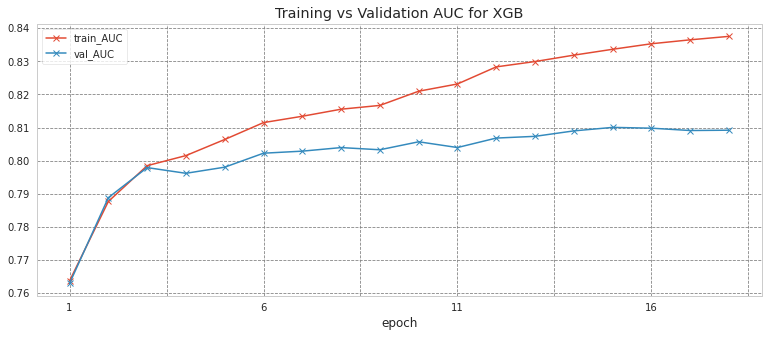

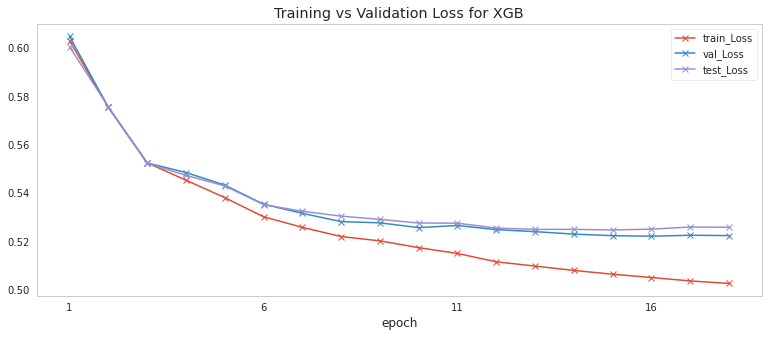

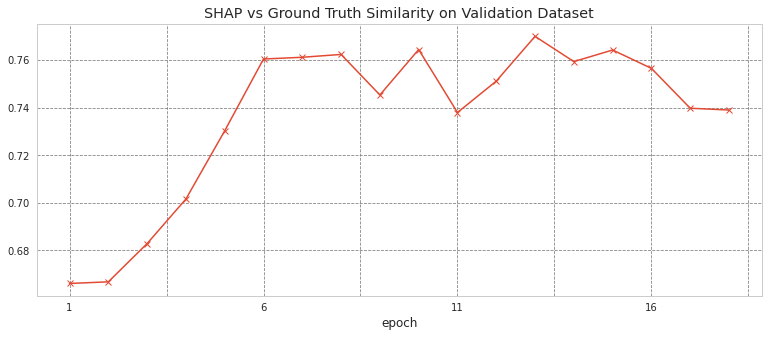

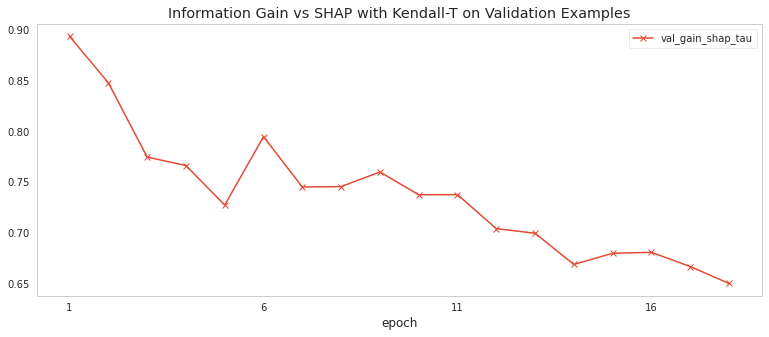

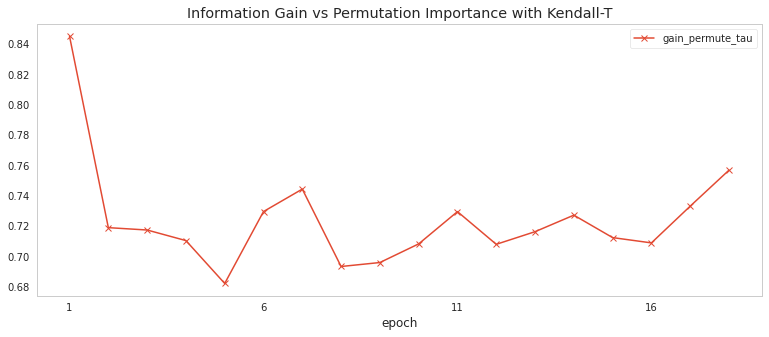

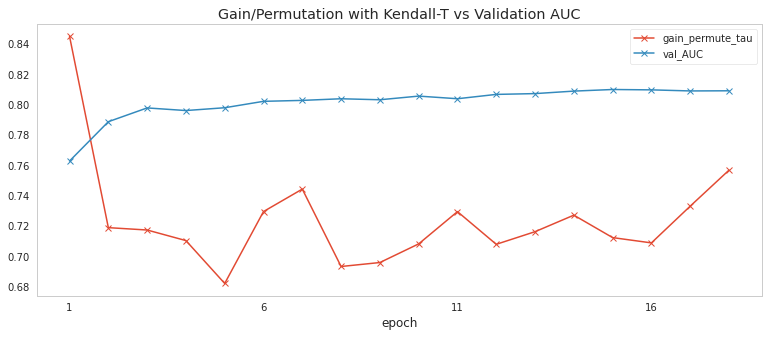

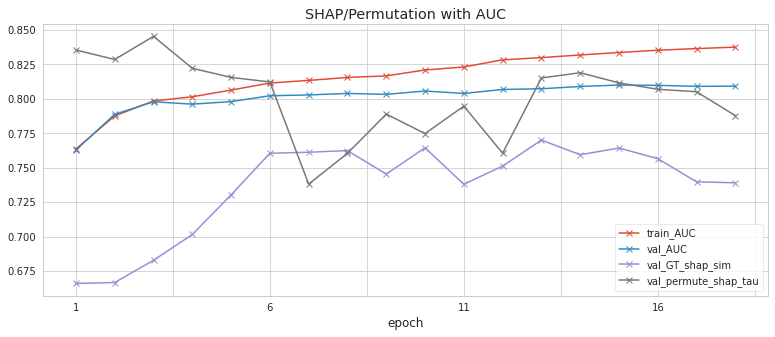

In [70]:
figsize = (13, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation AUC for XGB")
plt.grid(color="gray", linestyle="--")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss", "test_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for XGB")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
    legend=False,
)
plt.title("SHAP vs Ground Truth Similarity on Validation Dataset")
plt.grid(color="gray", linestyle="--")


df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_gain_shap_tau"],
    kind="line",
    marker="x",
)
plt.title("Information Gain vs SHAP with Kendall-T on Validation Examples")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["gain_permute_tau"],
    kind="line",
    marker="x",
)
plt.title("Information Gain vs Permutation Importance with Kendall-T")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["gain_permute_tau", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Gain/Permutation with Kendall-T vs Validation AUC")


df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=[
        "train_AUC",
        "val_AUC",
        "val_GT_shap_sim",
        "val_permute_shap_tau",
    ],
    kind="line",
    marker="x",
)
plt.title("SHAP/Permutation with AUC")
plt.grid()
plt.show()

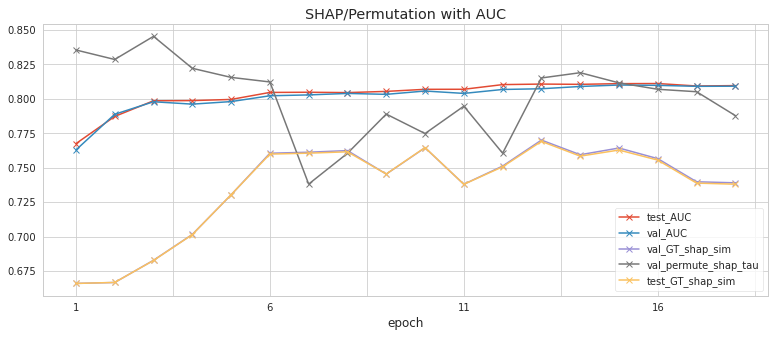

In [71]:
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=[
        "test_AUC",
        "val_AUC",
        "val_GT_shap_sim",
        "val_permute_shap_tau",
        "test_GT_shap_sim",
    ],
    kind="line",
    marker="x",
)
plt.title("SHAP/Permutation with AUC")
plt.grid()
plt.show()

# Save figures

In [72]:
plt.style.use("ggplot")

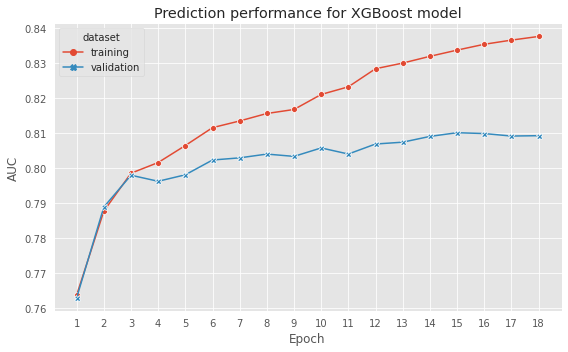

In [73]:
train_df = imp_utils.ret_label_df(df_results.reset_index(), "train_AUC", "training")
val_df = imp_utils.ret_label_df(df_results.reset_index(), "val_AUC", "validation")
plot_df = pd.concat([train_df, val_df])
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df,
    x="epoch",
    y="AUC",
    hue="dataset",
    markers=True,
    dashes=False,
    style="dataset",
)
ax.set_title("Prediction performance for XGBoost model")
ax.set_xlabel("Epoch")
plt.tight_layout()
plt.show()

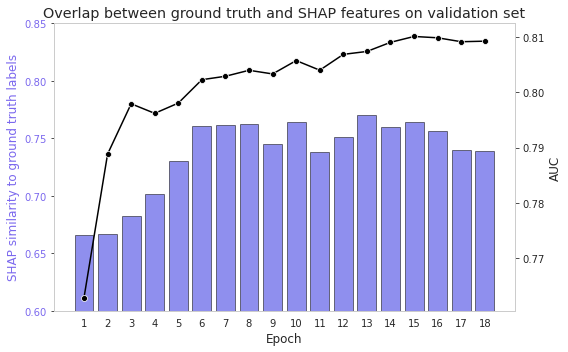

In [74]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.6, 0.85))
ax.set_xlabel("Epoch")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("Overlap between ground truth and SHAP features on validation set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plt.show()

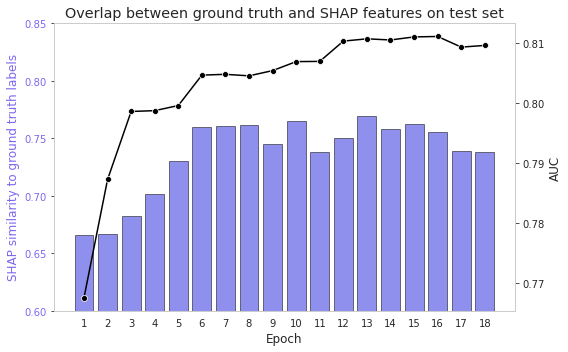

In [75]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.6, 0.85))
ax.set_xlabel("Epoch")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("Overlap between ground truth and SHAP features on test set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plt.show()

# Visualize SHAP

In [76]:
best_epoch = imp_utils.get_best_epoch(df_results)
best_epoch

15

In [77]:
split = "test"
new_path = IMP_SAVE_PATH_PATTERN.format(split, best_epoch)

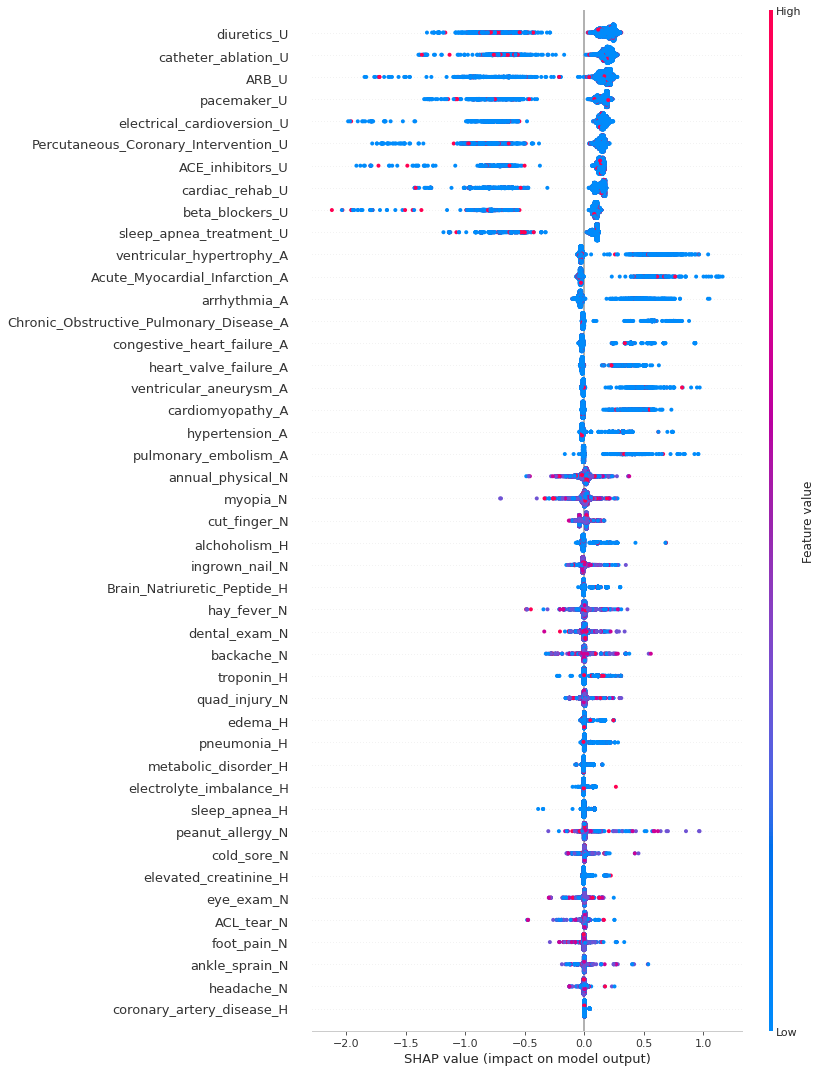

In [78]:
with open(new_path, "rb") as fp:
    all_shap = pickle.load(fp)
features, shap_values = imp_utils.get_xgb_shap_values_and_features(all_shap)
val_plot_df = pd.read_csv(x_VALID_ONE_HOT_PATH)
# For summary plot
shap.summary_plot(
    shap_values,
    val_plot_df[features],
    feature_names=features,
    max_display=len(features),
    show=False,
)
fig = plt.gcf()
# Global Feature importance
# shap.summary_plot(shap_values, features=features, plot_type="bar")
fig.set_size_inches(12, 15)
plt.tight_layout()
plt.show()

## Plot similarity between global SHAP vs Information Gain

In [79]:
epochs = range(1, len(model_paths) + 1)
figsize = (8, 8)

tau_corr = []
for epoch in [best_epoch]:
    shap_path = IMP_SAVE_PATH_PATTERN.format("val", epoch)
    mod_path = MODEL_SAVE_PATH.format(epoch)
    xgb_model = imp_utils.load_pickle(mod_path)
    val_results = imp_utils.load_pickle(shap_path)
    xgb_gain = pd.DataFrame((xgb_model.get_score(importance_type="gain")).items())
    xgb_gain.columns = ["features", "xgb_gain"]
    xgb_gain["xgb_gain_rank"] = xgb_gain["xgb_gain"].rank(ascending=False)

    df_shap = imp_utils.get_xgb_features_and_global_shap(val_results)
    df_shap.rename(columns={"scores": "shap_scores"}, inplace=True)
    df_shap["shap_rank"] = df_shap["shap_scores"].rank(ascending=False)

    gain_shap_df = xgb_gain[["features", "xgb_gain", "xgb_gain_rank"]].merge(
        df_shap[["features", "shap_scores", "shap_rank"]], how="inner", on="features"
    )

    tau_score = imp_utils.get_wtau(gain_shap_df.xgb_gain, gain_shap_df.shap_scores)
    tau_corr.append(tau_score)

In [80]:
gain_shap_df.head()

,features,xgb_gain,xgb_gain_rank,shap_scores,shap_rank
0,diuretics_U,95.855755,5.0,0.246957,1.0
1,ARB_U,95.992573,4.0,0.228223,3.0
2,pacemaker_U,95.269811,6.0,0.213670,4.0
3,cardiac_rehab_U,94.430994,7.0,0.190408,8.0
4,sleep_apnea_treatment_U,110.918072,1.0,0.154061,10.0


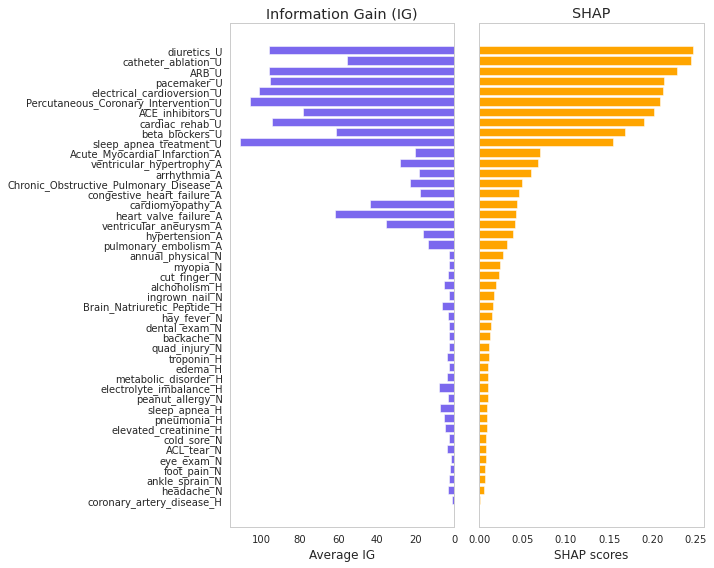

In [81]:
gain_shap_df.sort_values("shap_scores", ascending=True, inplace=True)

fig = plt.figure(figsize=(10, 8))
axes = fig.subplots(ncols=2, sharey=True)
#        row.bar(
#            df['features'], df[epoch_col], 0.8, label=epoch_col, color=color, edgecolor='black')
axes[0].barh(
    gain_shap_df.features,
    gain_shap_df.xgb_gain,
    color="mediumslateblue",
    align="center",
    zorder=10,
)
axes[0].set(title="Information Gain (IG)", xlabel="Average IG")
axes[1].barh(
    gain_shap_df.features, gain_shap_df.shap_scores, color="orange", align="center"
)
axes[1].set(title="SHAP", xlabel="SHAP scores")
axes[0].invert_xaxis()
# axes[1].set_yticks([])
fig.subplots_adjust(wspace=0.09)
plt.tight_layout()
plt.show()

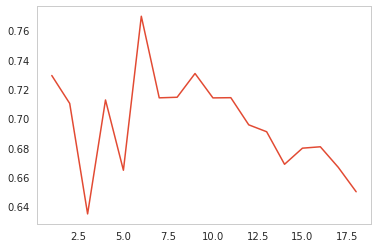

In [82]:
tau_corr = []
for epoch in epochs:
    shap_path = IMP_SAVE_PATH_PATTERN.format("val", epoch)
    mod_path = MODEL_SAVE_PATH.format(epoch)
    xgb_model = imp_utils.load_pickle(mod_path)
    val_results = imp_utils.load_pickle(shap_path)
    xgb_gain = pd.DataFrame((xgb_model.get_score(importance_type="gain")).items())
    xgb_gain.columns = ["features", "xgb_gain"]
    xgb_gain["xgb_gain_rank"] = xgb_gain["xgb_gain"].rank(ascending=False)

    df_shap = imp_utils.get_xgb_features_and_global_shap(val_results)
    df_shap.rename(columns={"scores": "shap_scores"}, inplace=True)
    df_shap["shap_rank"] = df_shap["shap_scores"].rank(ascending=False)

    gain_shap_df = xgb_gain[["features", "xgb_gain", "xgb_gain_rank"]].merge(
        df_shap[["features", "shap_scores", "shap_rank"]], how="inner", on="features"
    )

    tau_score = imp_utils.get_wtau(gain_shap_df.xgb_gain, gain_shap_df.shap_scores)
    tau_corr.append(tau_score)

plt.plot(epochs, tau_corr)
plt.show()

# Distribution of similarities

In [83]:
valpath = IMP_SAVE_PATH_PATTERN.format("val", best_epoch)
testpath = IMP_SAVE_PATH_PATTERN.format("test", best_epoch)

In [84]:
with open(valpath, "rb") as fp:
    all_shap = pickle.load(fp)
val_features, val_shap_values = imp_utils.get_xgb_shap_values_and_features(all_shap)

with open(testpath, "rb") as fp:
    all_shap = pickle.load(fp)
tst_features, tst_shap_values = imp_utils.get_xgb_shap_values_and_features(all_shap)

In [85]:
all_scores = val_shap_values
all_tokens = [val_features] * len(val_shap_values)
avg_sim, val_sim = imp_utils.get_all_intersection_similarity(
    all_scores, all_tokens, freedom=0, is_synthetic=IS_SYNTHETIC
)

all_scores = tst_shap_values
all_tokens = [tst_features] * len(tst_shap_values)
avg_sim, tst_sim = imp_utils.get_all_intersection_similarity(
    all_scores, all_tokens, freedom=0, is_synthetic=IS_SYNTHETIC
)

In [86]:
pd.DataFrame(val_sim).describe()

,0
count,7000.000000
mean,0.764329
std,0.041755
min,0.600000
25%,0.733333
50%,0.766667
75%,0.800000
max,0.900000


In [87]:
pd.DataFrame(tst_sim).describe()

,0
count,7000.000000
mean,0.762862
std,0.041947
min,0.600000
25%,0.733333
50%,0.766667
75%,0.800000
max,0.900000


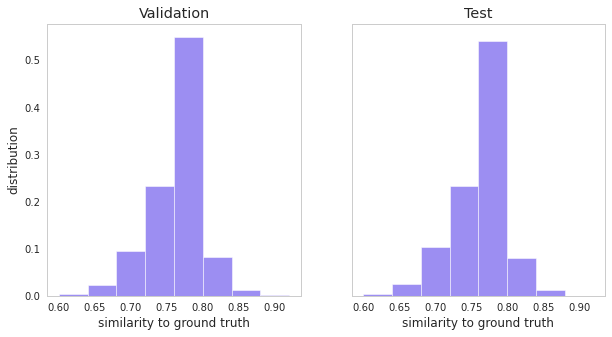

In [88]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(10, 5))
sns.histplot(
    val_sim, ax=ax1, binwidth=0.04, color="mediumslateblue", stat="probability"
)
ax1.set_xlabel("similarity to ground truth")
ax1.set_title("Validation")
ax1.set_ylabel("distribution")
sns.histplot(
    tst_sim, ax=ax2, binwidth=0.04, color="mediumslateblue", stat="probability"
)
ax2.set_xlabel("similarity to ground truth")
ax2.set_title("Test")
plt.show()

## Plot Global Importance per Epoch

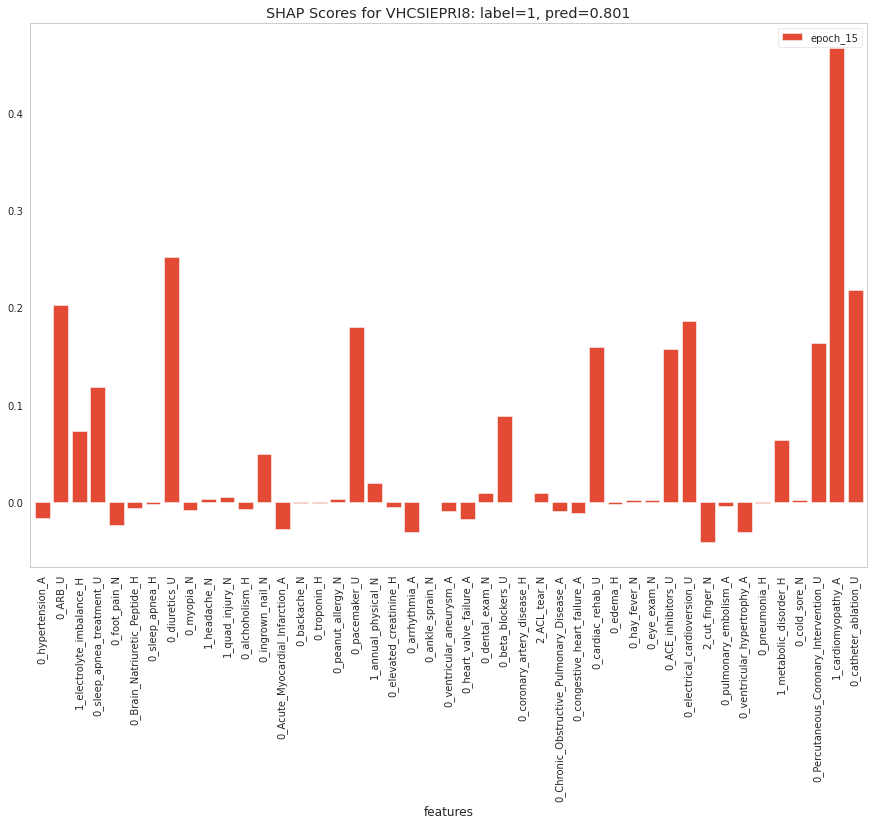

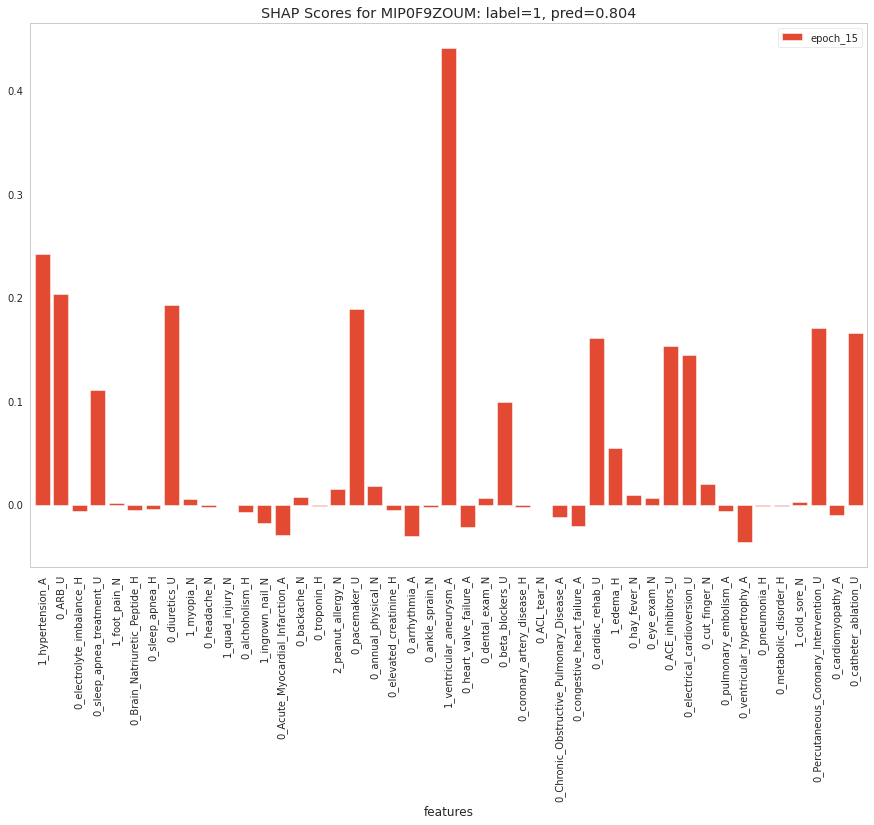

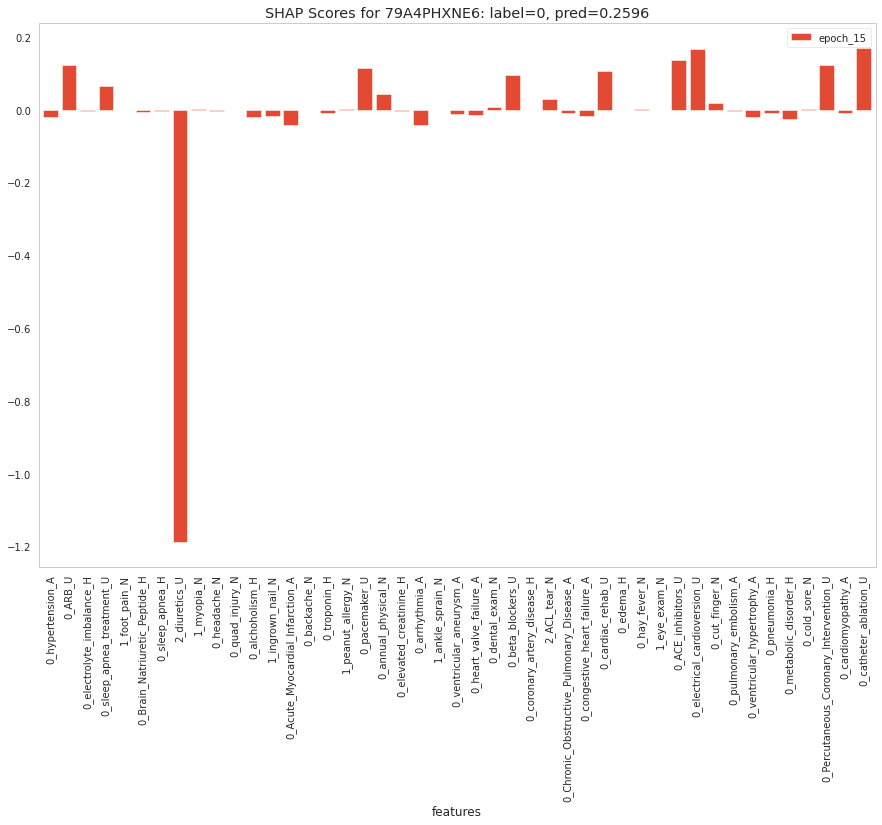

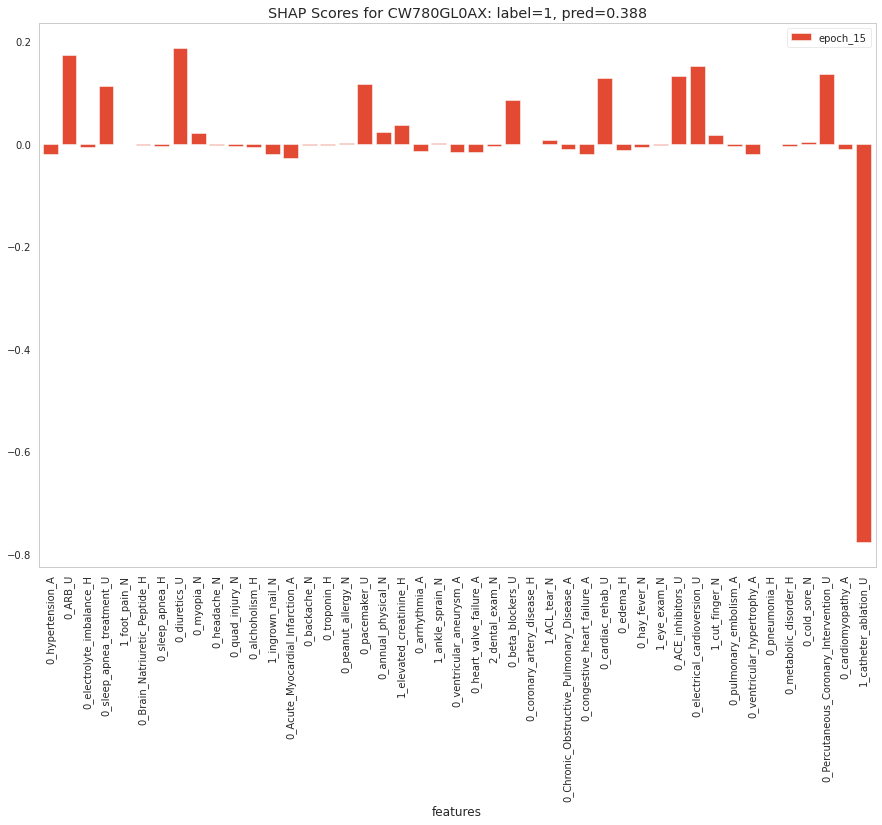

In [89]:
n_jobs = len(model_paths)
epochs = [best_epoch]  # n_jobs+1) #range(1, len(model_paths) + 1, step)
for patient_id in SELECTED_PATIENTS:
    df = pd.DataFrame()
    label = None
    pred_prob = None
    for epoch in epochs:
        shap_path = IMP_SAVE_PATH_PATTERN.format("test", epoch)
        test_results = imp_utils.load_pickle(shap_path)
        if not len(df):
            features = test_results[patient_id]["features_xgb"]
            df["features"] = features
            df["values"] = df_test[features][
                df_test["patient_id"] == patient_id
            ].values[0]
            df["features"] = df["values"].astype(str) + "_" + df["features"]
            label = test_results[patient_id]["label"]
        pred_prob = test_results[patient_id]["xgb_pred"]
        df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]
    figsize = (15, 10)
    epoch_cols = [f"epoch_{epoch}" for epoch in epochs]
    df.plot(
        figsize=figsize,
        x="features",
        y=epoch_cols,
        kind="bar",
        width=0.8,
    )
    plt.title(f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}")
    plt.show()

In [90]:
best_epoch_shap = imp_utils.get_best_epoch(df_results, by="val_GT_shap_sim")
best_epoch_shap

13

FixedFormatter should only be used together with FixedLocator


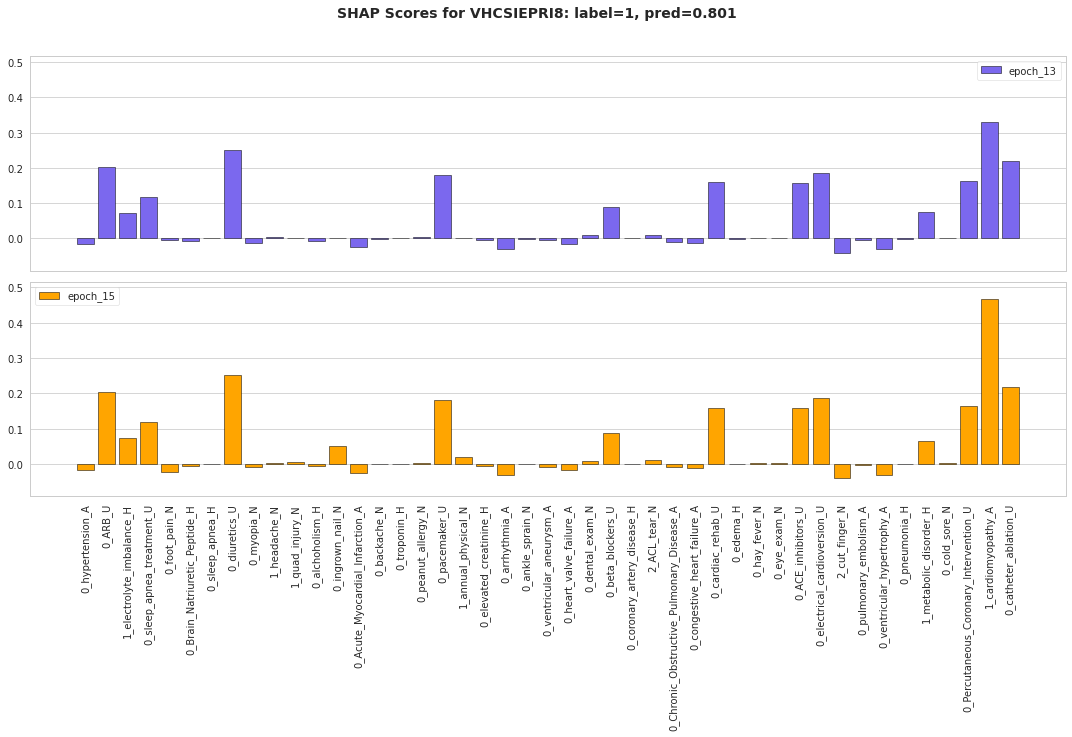

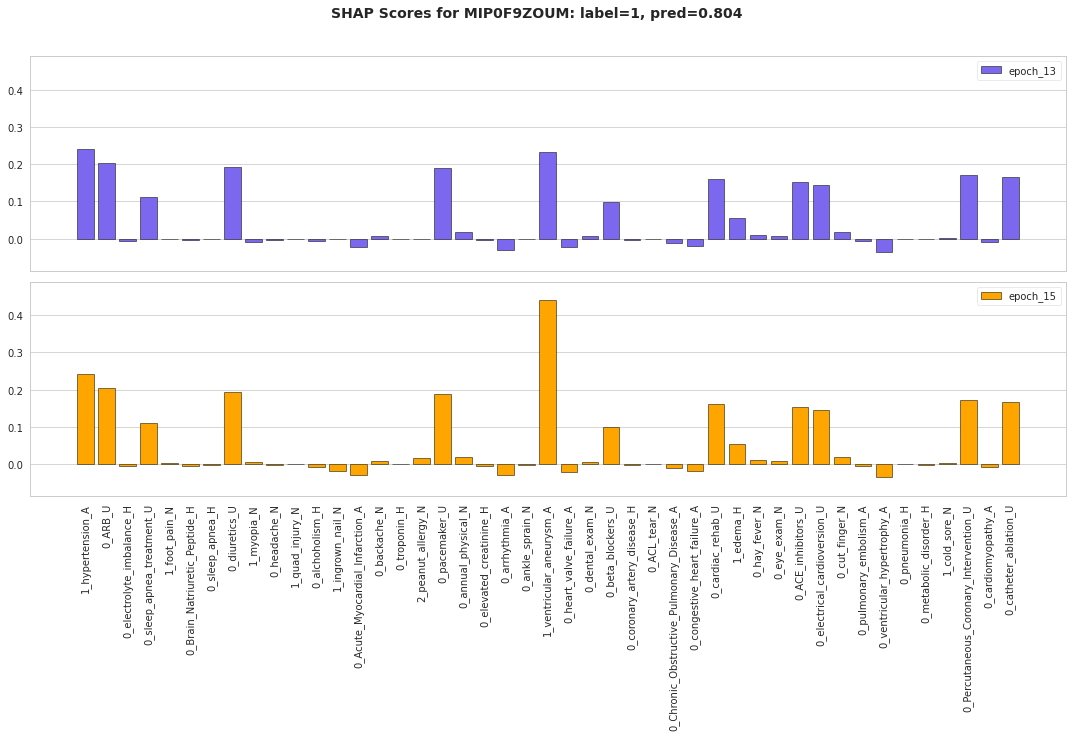

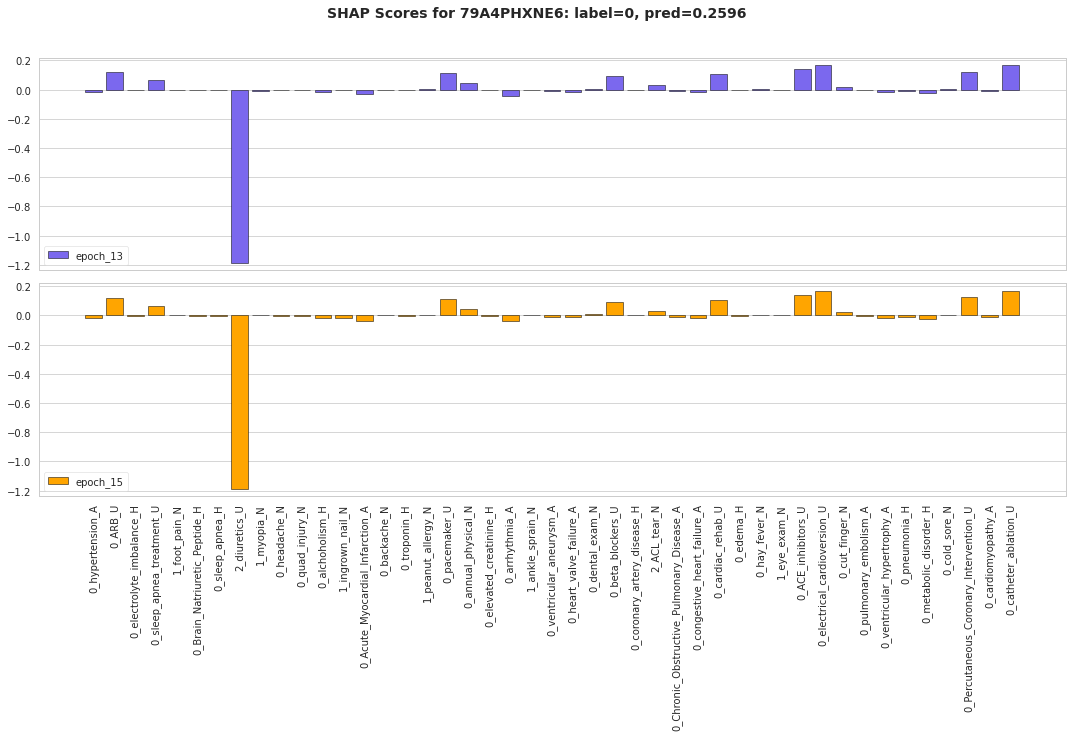

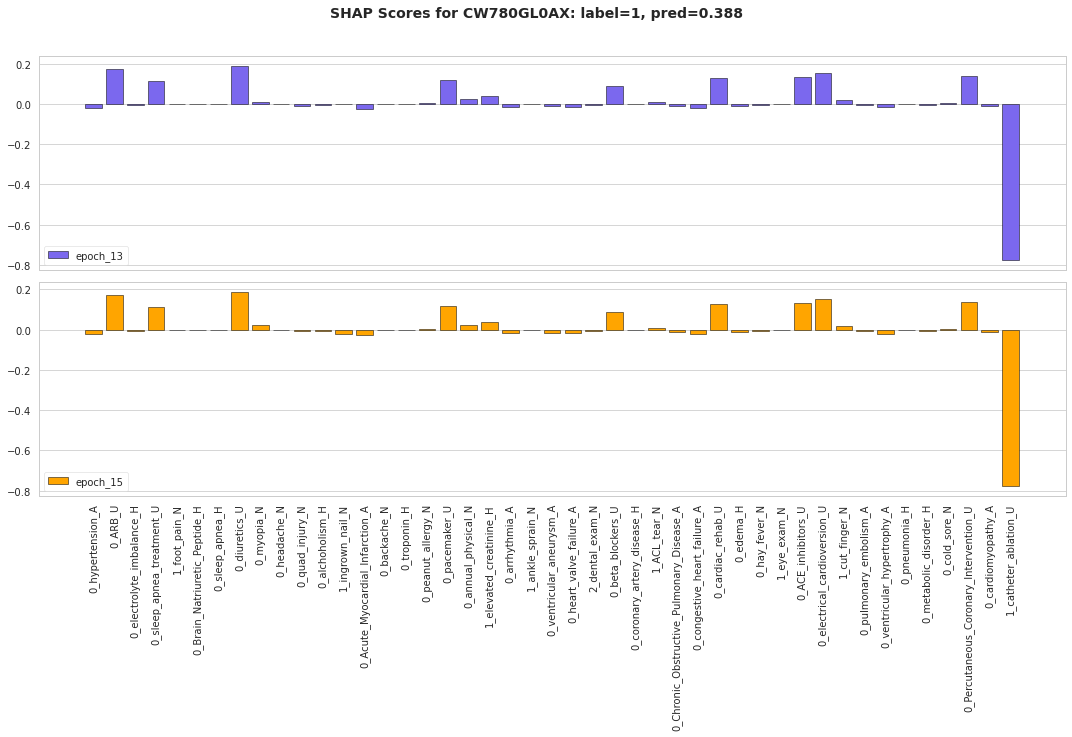

In [91]:
epochs = sorted([best_epoch_shap, best_epoch])
for patient_id in SELECTED_PATIENTS:
    df = pd.DataFrame()
    label = None
    pred_prob = None
    for epoch in epochs:
        shap_path = IMP_SAVE_PATH_PATTERN.format("test", epoch)
        test_results = imp_utils.load_pickle(shap_path)
        if not len(df):
            features = test_results[patient_id]["features_xgb"]
            df["features"] = features
            df["values"] = df_test[features][
                df_test["patient_id"] == patient_id
            ].values[0]
            df["features"] = df["values"].astype(str) + "_" + df["features"]
            label = test_results[patient_id]["label"]
        pred_prob = test_results[patient_id]["xgb_pred"]
        df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]

    figsize = (15, 10)
    epoch_cols = [f"epoch_{epoch}" for epoch in epochs]

    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1)
    min_y, max_y = (
        df[epoch_cols].values.min() - 0.05,
        df[epoch_cols].values.max() + 0.05,
    )
    for row, epoch_col, color in zip(axes, epoch_cols, ["mediumslateblue", "orange"]):
        row.bar(
            df["features"],
            df[epoch_col],
            0.8,
            label=epoch_col,
            color=color,
            edgecolor="black",
        )
        if epoch_col != epoch_cols[-1]:
            row.set_xticks([])
        else:
            row.set_xticklabels(df["features"].tolist(), rotation=90)
        row.grid(axis="y")
        row.set_ylim((min_y, max_y))
        row.legend()

    plt.tight_layout()
    st = fig.suptitle(
        f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}",
        fontsize=14,
        fontweight="bold",
    )
    # st.set_y(0.95)
    st.set_y(1.02)
    fig.subplots_adjust(top=0.90)

    plt.tight_layout()
    plt.show()